Perform blocks in parallel:

    for site in sites:
        Download 5-minute data    
        Append data to regional dataframe
    With regional dataframe:
        Calculate sea-level-normalized temperature for each site
        Write sea-level-normalized temperature to dataframe

    Download elevation data
    With elevation data:
        With rasterio, load into raster
        Downscale as necessary
    
    Download RAP data (optional)


With elevation numpy array:  
    Create new np array with the same dimensions as the elevation data  
    Use a linear (or other) interpolation method on sea-level-normalized temperature at each pixel  
    Optionally correct/weight points far away from sensors with sea-level-normalized RAP data  
    Print numpy array to raster output (optional for debugging)  
    numpy array calculation; use sea-level temperature and altitude arrays to determine surface temperature at each pixel
    Print temperature array to raster output (final output)  
    Print an uncertainty array  
    Upload outputs to S3  
  
    
    
  

In [1]:
import json
import os
import urllib

from matplotlib import pyplot as plt
import metpy.calc
import numpy as np
import pandas as pd
import pint
import scipy.interpolate

from metpy.units import units
import rasterio

In [2]:
# Configuration
cwd = os.getcwd()

MESONET_DATA_URL = "http://xmountwashington.appspot.com/mmNew.php?callback=null"

TARGET_DEM_URL = "https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/ArcGrid/USGS_NED_13_n45w072_ArcGrid.zip"
TARGET_DEM_FILE_ZIP = os.path.join(cwd, "tmp/dem.zip")
TARGET_DEM_FILE_UNZIP = os.path.join(cwd, "data/dem")
TARGET_DEM_DATA_FILE = os.path.join(TARGET_DEM_FILE_UNZIP, "grdn45w072_13", "w001001.adf")

TARGET_RAP_DIR = os.path.join(cwd, "data/rap")

# A ratio of number-of-datapoints-in-input-dem to number-of-datapoints-in-output-dem
OUTPUT_RESOLUTION = 1/10

In [3]:
def make_item(json):
    '''
    Takes a json object and creates an items' dataframe
    '''
    df = pd.DataFrame(columns=["siteName", "siteLat", "siteLon", "siteAltitude", "temperature", "potential_temperature"])
    for site in json:
        if "temperature" in json[site]:
            df = df.append({"siteName": site, 
                            "siteLat": json[site]["latitude"],
                            "siteLon": json[site]["longitude"],
                            "siteAltitude": units.meters,
                            "temperature": float(json[site]["temperature"]) * units.degF,
                            "potential_temperature": units.degF
                           }, 
                           ignore_index=True)
    populate_alt_from_dem(df)
    return df


def populate_alt_from_dem(df, file=TARGET_DEM_DATA_FILE):
    with rasterio.open(file) as dem:
        dem_arr = np.squeeze(dem.read())
        for i, row in df.iterrows():
            site_y_pixel, site_x_pixel = dem.index(row["siteLon"], row["siteLat"])    
            df.at[i, 'siteAltitude'] = dem_arr[site_y_pixel][site_x_pixel] * units.meters
    
    
def get_potential_temperature(df):
    for i, row in df.iterrows():
        if "pressure" not in row:
            pressure = metpy.calc.height_to_pressure_std(row["siteAltitude"])
        else:
            pressure = row["pressure"]
            
        if "dewpoint" in row:
            # calculate equivalent potential temperature
            potential_temperature = metpy.calc.equivalent_potential_temperature(pressure, row["temperature"], row["dewpoint"])
        else:
            # calculate potential temperature

            potential_temperature = metpy.calc.potential_temperature(pressure, row["temperature"])
        df.at[i,'potential_temperature'] = potential_temperature
        
            
# Should be as simple as pd.read_json once we figure out the callback issue
#pd.read_json('http://xmountwashington.appspot.com/mmNew.php')

In [4]:
import os
import urllib.request
import zipfile

def download_file(url, target, clobber=False):
    # TODO; move this to an S3 call
    make_dirs_if_no_exists(target)
    print("Downloading file %s" % url)
    if os.path.exists(target) and not clobber:
        print("Path %s already exists; using previoiusly downloaded file." % target)
        return False
    urllib.request.urlretrieve(url, target)  
    return True

        
def extract_file(source, target, delete_source=False):
    make_dirs_if_no_exists(target)
    print("Unzipping file %s to %s." % (source, target))
    with zipfile.ZipFile(source,"r") as zip_ref:
        zip_ref.extractall(target)
    

def make_dirs_if_no_exists(dirname):
    if not os.path.exists(os.path.dirname(dirname)):
        print("Path %s does not exist.  Attempting to make it now." % os.path.dirname(dirname))
        os.makedirs(os.path.dirname(dirname))

In [5]:
# Driver for download and extraction of DEM data
# Must occur first so altitude data can be determined in the mesonet dataframe

if download_file(TARGET_DEM_URL, TARGET_DEM_FILE_ZIP):
    extract_file(TARGET_DEM_FILE_ZIP, TARGET_DEM_FILE_UNZIP)

Path /external/mesonet-interpolation/temperature/tmp/dem.zip already exists; using previoiusly downloaded file.


In [38]:
# Driver for download and reading of RAP model data
import pygrib

# TODO; pull from the DEM file instead (these values should match)
minRAPLat = 43.5
maxRAPLat = 45.5
minRAPLon = -72.5
maxRAPLon = -69.5

# TODO; grab newest RAP file
#RAP_URL = "https://nomads.ncdc.noaa.gov/data/rap130/201907/20190708/rap_130_20190708_0000_000.grb2"
RAP_URL = "ftp://ftp.ncep.noaa.gov/pub/data/nccf/com/rtma/prod/rtma2p5_ru.20190714/rtma2p5_ru.t0000z.2dvaranl_ndfd.grb2"
#TARGET_RAP_FILE = os.path.join(TARGET_RAP_DIR, "rap_130_20190708_0000_000.grb2")
TARGET_RAP_FILE = os.path.join(TARGET_RAP_DIR, "test2.grb2")

_ = download_file(RAP_URL, TARGET_RAP_FILE)
with pygrib.open(TARGET_RAP_FILE) as grbs:
    grbs.seek(0)
    for grb in grbs:
        print(grb)
    #raise
    pot_temp = grbs.select(name='2 metre temperature')[0]
    #temp = grbs.select(name='Derived radar reflectivity')[0]
    #print(temp.data())
    #plt.imshow(temp.data()[0])
    #plt.show()
    potential_temp_data, potential_temp_lats, potential_temp_lons = pot_temp.data(lat1=minRAPLat, lat2=maxRAPLat, lon1=minRAPLon, lon2=maxRAPLon)
    print(potential_temp_data.size)
    print(potential_temp_data.min())
    


Path /external/mesonet-interpolation/temperature/data/rap/test2.grb2 already exists; using previoiusly downloaded file.
1:Orography:m (instant):lambert:surface:level 0:fcst time 0 mins:from 201907140000
2:Surface pressure:Pa (instant):lambert:surface:level 0:fcst time 0 mins:from 201907140000
3:2 metre temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 mins:from 201907140000
4:2 metre dewpoint temperature:K (instant):lambert:heightAboveGround:level 2 m:fcst time 0 mins:from 201907140000
5:10 metre U wind component:m s**-1 (instant):lambert:heightAboveGround:level 10 m:fcst time 0 mins:from 201907140000
6:10 metre V wind component:m s**-1 (instant):lambert:heightAboveGround:level 10 m:fcst time 0 mins:from 201907140000
7:Specific humidity:kg kg**-1 (instant):lambert:heightAboveGround:level 2 m:fcst time 0 mins:from 201907140000
8:10 metre wind direction:Degree true (instant):lambert:heightAboveGround:level 10 m:fcst time 0 mins:from 201907140000
9:10 metre wind spee

In [7]:
# Driver for downloading mesonet data and performing point calculations

with urllib.request.urlopen(MESONET_DATA_URL) as response:
    callback = response.read()
json_string = callback.decode("utf8").rstrip(')').lstrip('null(')
mesonet_data = json.loads(json_string)
df = make_item(mesonet_data['currentMesonetConditions'])
get_potential_temperature(df)


284.34000000000003
299.84000000000003


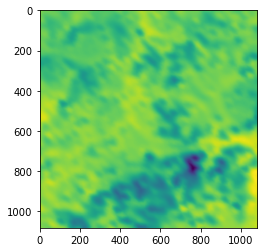

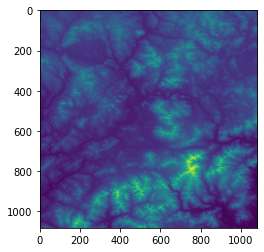

In [41]:
# Driver that combines mesonet and DEM data

with rasterio.open(TARGET_DEM_DATA_FILE) as dem:
    dem_arr = dem.read()
    
    output_res_step = int(1/OUTPUT_RESOLUTION)
    
    x = np.arange(0, dem.width, output_res_step)
    y = np.arange(0, dem.height, output_res_step)
    X, Y = np.meshgrid(x,y)
    
    dem_arr = np.squeeze(dem_arr)
    condensed_altitudes = dem_arr[0:dem.height:output_res_step, 0:dem.width:output_res_step]
    
    x_pixels = []
    y_pixels = []
    values = []
    
    #for i, row in df.iterrows():
    #    site_y_pixel, site_x_pixel = dem.index(row["siteLon"], row["siteLat"])    
    #    x_pixels.append(site_x_pixel)
    #    y_pixels.append(site_y_pixel)
    #    values.append(row["potential_temperature"].magnitude)
    #print(min(values))
    #print(max(values))
    for i in range(0, potential_temp_data.size):
        site_y_pixel, site_x_pixel = dem.index(potential_temp_lons[i], potential_temp_lats[i])    
        x_pixels.append(site_x_pixel)
        y_pixels.append(site_y_pixel)
        values.append(potential_temp_data[i])
    print(min(values))
    print(max(values))    
    potential_temperature_interpolated_cubic = scipy.interpolate.griddata((np.asarray(x_pixels), np.asarray(y_pixels)), np.asarray(values), (X, Y), method="cubic")
    plt.imshow(potential_temperature_interpolated_cubic)
    plt.show()
    
    pressure = metpy.calc.height_to_pressure_std(condensed_altitudes * units.meters)
    temperature = metpy.calc.temperature_from_potential_temperature(pressure, potential_temperature_interpolated_cubic * units.degF)
    plt.imshow(condensed_altitudes)
    plt.show()
    

In [33]:
print(df)
for i, row in df.iterrows():
    x_pixel_output = x_pixels[i] * OUTPUT_RESOLUTION
    y_pixel_output = y_pixels[i] * OUTPUT_RESOLUTION
    site_temperature_output = temperature[int(x_pixel_output), int(y_pixel_output)]
    temperature_diff = site_temperature_output - row["temperature"]
    print(temperature_diff)
        
print(np.min(temperature.to(units.degF)))
print(np.max(temperature.to(units.degF)))

   siteName    siteLat    siteLon              siteAltitude temperature  \
0      AR16  44.290001 -71.226652    475.677001953125 meter   65.2 degF   
1      AR23  44.281127 -71.246320     700.66552734375 meter   63.7 degF   
2      AR33  44.286711 -71.265723   998.4877319335938 meter   61.6 degF   
3      AR40  44.295376 -71.279357       1234.78515625 meter   62.3 degF   
4      AR43  44.289447 -71.279734  1335.1595458984375 meter   59.9 degF   
5      AR53  44.281442 -71.292144      1656.255859375 meter   56.1 degF   
6      ATTI  44.070604 -71.219595   672.7703247070312 meter   70.8 degF   
7      BRWD  44.254531 -71.465018   612.1685791015625 meter   68.3 degF   
8      CANN  44.157722 -71.699151  1229.8980712890625 meter   61.3 degF   
9      CRAN  44.057569 -71.092848   509.2892150878906 meter   73.5 degF   
10     HICR  44.220293 -71.411553    580.104248046875 meter   65.4 degF   
11     JACK  44.132400 -71.155600   696.0803833007812 meter   70.8 degF   
12     MIZP  44.219442 -7